# Prediction on the Income Dataset via Machine Learning
## Nick Heise
### December 2018

<ol>
    <li>Introduction</li>
    <li>Reading and Cleaning of Dataset</li>
    <li>One-Hot Encoding of Categorical Data</li>
    <li>Scaling the Continuous Data</li>
    <li>Machine Learning</li>
    <ol>
        <li>Initial Training and Model Selection</li>
        <li>Feature Selection</li>
    </ol>
    <li>Conclusion</li>
</ol>

## 1. Introduction

<p>This notebook manipulates the data of the income dataset, trains machine learning models, and selects the optimal features and model for predicting if an individual earns more than 50k or not. For an analysis of the dataset, please read the other jupyter notebook included in this project (analysis_notebook.ipynb).</p>

In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

pd.set_option('display.max_columns', None)
sns.set_palette(palette=sns.color_palette('colorblind'))

## 2. Reading and Cleaning of Dataset

<p>The dataset given was scraped without column names. Fortunately, we have been given a metadeta document detailing the various columns, their data types, and their values. We'll use the columns provided in this document to properly set the columns.</p>
<p>Note that original income-related columns were removed, and the binary 'income' column was added. Further, as detailed in the metadeta document, 'instance_weight' should not be used for classification and is therefore removed.<p>

In [2]:
train_df =  pd.read_csv(os.path.join('census_income_data', 'census_income_learn.csv'))
test_df = pd.read_csv(os.path.join('census_income_data', 'census_income_test.csv'))

column_names = ['age', 'class_of_worker', 'industry_code', 'occupation_code',
                'education', 'wage_per_hour', 'enrolled_in_edu_inst_last_wk',
                'marital_status', 'major_industry_code', 'major_occupation_code', 'race', 
                'hispanic_origin', 'sex', 'member_of_a_labor_union', 'reason_for_unemployment', 
                'full_or_part_time_employment_stat', 'capital_gains', 'dividends_from_stocks',
                'federal_income_tax_liability', 'tax_filer_status', 'region_of_previous_residence', 
                'state_of_previous_residence', 'detailed_household_and_family_stat', 
                'detailed_household_summary_in_household', 'instance_weight',
                'migration_code_change_in_msa', 'migration_code_change_in_reg', 
                'migration_code_move_within_reg', 'live_in_this_house_1yr_ago', 
                'migration_prev_res_in_sunbelt', 'num_persons_worked_for_employer',
                'family_persons_under_18', 'country_of_birth_father', 
                'country_of_birth_mother', 'country_of_birth_self', 'citizenship', 
                'own_business_or_self_employed', 'fill_inc_questionnaire_for_veterans_admin', 
                'veterans_benefits', 'weeks_worked_in_year', 'year', 'income']
                
for df in [train_df, test_df]:
    df.columns = column_names
    df.drop(labels='instance_weight', axis='columns', inplace=True)

In [3]:
print('Training set has {} samples, with {} columns.'.format(train_df.shape[0], train_df.shape[1]))
print('Test set has {} samples, with {} columns.'.format(test_df.shape[0], test_df.shape[1]))

Training set has 199522 samples, with 41 columns.
Test set has 99761 samples, with 41 columns.


<p>The target column for this dataset, 'income', contains a string value: '-50000' or '50000+'. In reality, we want this column be a binary value where 1 corresponds to the person earning over 50,000 dollars, and 0 corresponds to earning less. Here we encode the values accordingly:</p>

In [4]:
label_enc = LabelEncoder()
for df in [train_df, test_df]:
    df['over_50k_income'] = label_enc.fit_transform(df['income'])
    df.drop(labels='income', axis='columns', inplace=True)

## 3. One-Hot Encoding of Categorical Data
### Motivation
<p>For best performance of training a model on categorical data, we would like to convert all categorical data features to one-hot encoded values. This allows the model to train properly on numerical data, but also avoids creating any false relationships as would be done via a simple encoding. For most of these features, there is no relationship between the categories (i.e. it cannot be said that a certain industry code 'is greater than' another, so we cannot just encode the values to 1, 2, 3, etc). While it could be said that some features do have this relation, such as education, we choose to perform a one-hot encoding on all categorical features.</p>
<p>It should be noted that this greatly increases the dimensionality of the dataset from around 40 to around 500 columns. This causes models to train much slower, which is why feature selection will performed to reduce the complexity and prevent over-fitting.</p>

In [5]:
categorical_features = ['class_of_worker',
                        'industry_code',
                        'occupation_code',
                        'education', 
                        'enrolled_in_edu_inst_last_wk', 
                        'marital_status',
                        'major_industry_code',
                        'major_occupation_code',
                        'race', 
                        'hispanic_origin', 
                        'sex', 
                        'member_of_a_labor_union', 
                        'reason_for_unemployment', 
                        'full_or_part_time_employment_stat',
                        'tax_filer_status', 
                        'region_of_previous_residence', 
                        'state_of_previous_residence', 
                        'detailed_household_and_family_stat', 
                        'detailed_household_summary_in_household', 
                        'migration_code_change_in_msa', 
                        'migration_code_change_in_reg', 
                        'migration_code_move_within_reg', 
                        'live_in_this_house_1yr_ago', 
                        'migration_prev_res_in_sunbelt',
                        'family_persons_under_18', 
                        'country_of_birth_father', 
                        'country_of_birth_mother', 
                        'country_of_birth_self', 
                        'citizenship', 
                        'own_business_or_self_employed', 
                        'fill_inc_questionnaire_for_veterans_admin', 
                        'veterans_benefits',
                        'year']

In [6]:
# perform the one-hot encoding for all categorical features
for feature in categorical_features:
    train_dummies = pd.get_dummies(data=train_df[feature], prefix=feature)
    train_df = pd.concat([train_df, train_dummies], axis=1)

    test_dummies = pd.get_dummies(data=test_df[feature], prefix=feature)
    test_df = pd.concat([test_df, test_dummies], axis=1)

# drop the original feature columns
for df in [train_df, test_df]:
    df.drop(labels=categorical_features, axis='columns', inplace=True)

## 4. Scaling the Continuous Data
### Motivation
<p>Some models perform very poorly on datasets with very different scales. For example, the logistic regression used in this project performs significantly better once data is scaled between 0 and 1. Thus, we want to apply this scaling to the continuous features of our dataset to optimise the performance of our model.</p>
<p>It is important to note that the scaler is fit to the train dataset values, and then used to transform both the train and test values. This is to ensure that test values are scaled according to the values used to train the model, which will produce the best result.</p>

In [7]:
cont_features = ['age', 
                 'wage_per_hour', 
                 'capital_gains', 
                 'dividends_from_stocks',
                 'federal_income_tax_liability', 
                 'num_persons_worked_for_employer',
                 'weeks_worked_in_year']

In [8]:
# scale the continuous values to be between 0 and 1
scaler = MinMaxScaler()
scaler.fit(train_df[cont_features])
for df in [train_df, test_df]:
    df[cont_features] = scaler.transform(df[cont_features])

c:\users\nick\pythonprojects\dataiku-test\venv\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Correcting after the transformations

<p>We notice that the train and test set no longer contain the same number of columns. This is because one of the categorical values in a train feature did not occur in the test set. We'll correct this by adding a column of zeros to indicate that no sample is part of that category.</p>

In [9]:
print('Training set has {} samples, with {} columns.'.format(train_df.shape[0], train_df.shape[1]))
print('Test set has {} samples, with {} columns.'.format(test_df.shape[0], test_df.shape[1]))

Training set has 199522 samples, with 511 columns.
Test set has 99761 samples, with 510 columns.


In [10]:
for col in train_df.columns:
    if col not in test_df.columns:
        test_df[col] = 0

<p>We can verify that the column lengths now match.</p>

In [11]:
print('Training set has {} samples, with {} columns.'.format(train_df.shape[0], train_df.shape[1]))
print('Test set has {} samples, with {} columns.'.format(test_df.shape[0], test_df.shape[1]))

Training set has 199522 samples, with 511 columns.
Test set has 99761 samples, with 511 columns.


## 5. Machine Learning

### A. Initial Training and Model Selection
<p>We would first like to train a few different models on the modified dataset in order to compare their performances. For this project, we compare three popular classification models: logistic regression, random forest, and gradient boosting.</p>

#### Parameters
<p>The parameters chosen for each model were kept close to the default values chosen by scikit-learn. For ensemble methods, choosing an estimator number between 64 and 128 typically provides best performance. Thus, we chose 100. For the logistic regression classifier, the solver was set to 'sag' or 'Stochastic Average Gradient'. This was chosen as it performs best on larger datasets, and is why the continuous features were scaled (according to scikit-learn documentation, 'sag' fast convergence is only guaranteed on features with approximately the same scale). We also increased the max iterations from the default 100 to 200 to ensure that the solver converges on this dataset.</p>

In [12]:
# create classifiers
logreg = LogisticRegression(solver='sag', max_iter=200, verbose=1, n_jobs=6)
rfc = RandomForestClassifier(n_estimators=100, n_jobs=6, verbose=1)
gradboost = GradientBoostingClassifier(n_estimators=100, verbose=1)

classifiers = [logreg, rfc, gradboost]
c_names = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']

# separate features and target columns
train_features = train_df.drop(labels='over_50k_income', axis='columns')
train_target = train_df['over_50k_income']

test_features = test_df.drop(labels='over_50k_income', axis='columns')
test_target = test_df['over_50k_income']

# train the models
for c in classifiers:
    c.fit(train_features, train_target)

# create a dataframe with the model and its score
scores = [c.score(test_features, test_target) for c in classifiers]
scores_df = pd.DataFrame({'name': c_names,
                          'score': scores})

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


convergence after 157 epochs took 143 seconds


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:  2.4min finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   10.6s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:   25.8s finished


      Iter       Train Loss   Remaining Time 
         1           0.4234            4.19m
         2           0.4030            3.67m
         3           0.3854            3.55m
         4           0.3736            3.70m
         5           0.3645            3.54m
         6           0.3551            3.55m
         7           0.3469            3.50m
         8           0.3390            3.64m
         9           0.3339            3.52m
        10           0.3276            3.43m
        20           0.2874            3.03m
        30           0.2694            2.60m
        40           0.2592            2.20m
        50           0.2523            1.82m
        60           0.2483            1.43m
        70           0.2448            1.06m
        80           0.2421           41.51s
        90           0.2404           20.21s
       100           0.2385            0.00s


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.4s finished


In [13]:
scores_df

,name,score
0,Logistic Regression,0.947986
1,Random Forest,0.948547
2,Gradient Boosting,0.954872


<p>The models take a few minutes to train, and we obtain an accuracy of around 95%. Gradient Boosting performs the best of the three, so we will use that model to select the most important features in order to reduce training time and increase accuracy.</p>

### B. Feature Selection

<p>Gradient Boosting produced the best score, so we will use that model to select the most important features in order to reduce training time and increase accuracy.  We can obtain these features directly from the classifier. It should be noted that we also attempted feature selection by the feature importances produced by the random forest classifier, but found that gradient boosting yielded better results with fewer chosen features. Here we have sorted the features by importance, and produced a bar graph:</p>

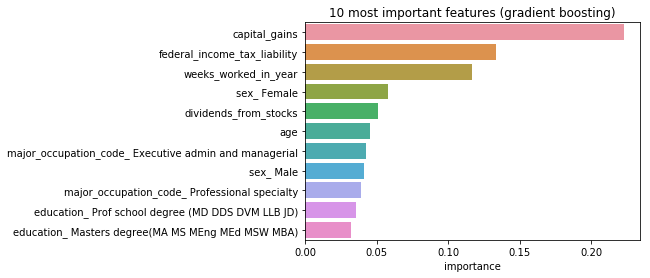

In [14]:
# create dataframe of feature importances
feature_importances_df = pd.DataFrame({'feature': train_features.columns,
                                       'importance': gradboost.feature_importances_})
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)
feature_importances_df.reset_index(inplace=True)

# display the most important features
top_feat_num = 10
ax = sns.barplot(x='importance', y=feature_importances_df[:top_feat_num+1].index, 
                 orient='h', 
                 data=feature_importances_df[:top_feat_num+1])
ax.set(title='{} most important features (gradient boosting)'.format(top_feat_num), 
       yticklabels=feature_importances_df.feature[:top_feat_num+1])
ax

<p>As discussed during the analysis, capital gains and federal income tax liability were the most important features in the gradient boosting model. Additionally, sex, age, and occupation code play important roles in the classifier's prediction.</p>
<p>Let's observe the histogram distribution of the feature importances.</p>

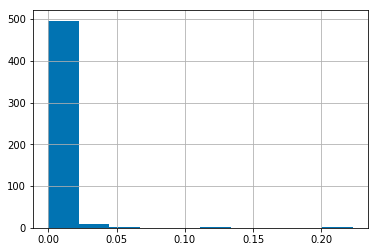

In [15]:
feature_importances_df['importance'].hist()

<p>Most features in the dataset have extremely low importance scores, which allows us to remove many of them and decrease the complexity of the model. Further, too many features can cause a model to overfit and thus it is good to reduce where possible. We are able to extract around 80 features and improve accuracy.</p>

In [16]:
extracted_features = feature_importances_df.loc[feature_importances_df['importance'] > 0.0001]

extracted_features_train = train_df[extracted_features['feature']]
extracted_features_test = test_df[extracted_features['feature']]

print('{} features were kept out of the original {}.'.format(extracted_features.shape[0], 
                                                             train_features.shape[1]))

78 features were kept out of the original 510.


In [17]:
# train models on datasets with only most important features
for c in classifiers:
    c.fit(extracted_features_train, train_target)

scores = [c.score(extracted_features_test, test_target) for c in classifiers]
scores_df = pd.DataFrame({'name': c_names,
                          'score': scores})

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


convergence after 45 epochs took 11 seconds


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:   10.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.2s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    9.8s finished


      Iter       Train Loss   Remaining Time 
         1           0.4234           40.48s
         2           0.4030           40.17s
         3           0.3854           36.44s
         4           0.3736           37.22s
         5           0.3645           36.00s
         6           0.3551           35.23s
         7           0.3469           34.48s
         8           0.3390           35.30s
         9           0.3339           34.01s
        10           0.3276           33.12s
        20           0.2874           29.47s
        30           0.2694           25.91s
        40           0.2592           22.59s
        50           0.2524           19.40s
        60           0.2483           15.26s
        70           0.2449           11.31s
        80           0.2420            7.43s
        90           0.2403            3.64s
       100           0.2385            0.00s


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.5s finished


In [18]:
scores_df

,name,score
0,Logistic Regression,0.953489
1,Random Forest,0.953970
2,Gradient Boosting,0.955223


<p>The training time has been greatly reduced and is now roughly 10 times faster, and we see that all models produce more accurate predictions on the test set. This indicates that we have correctly selected features and have produced more generalizable models.</p>

## 6. Conclusion

<p>We were able to produce a gradient boosting classification model with an accuracy of 95.5% on the provided test set, using scaled and encoded features to provide the best performance. This is a ~2% improvement on the most basic prediction of 0 for all samples, so we have achieved a better predictor of individuals who earn more than 50k income.</p>
<p>The dataset contains many nonlinear relationships between features and the target column. Thus, it would potentially be a good opportunity to use a neural network as they tend to be the more accurate models on highly nonlinear datasets. However, neural networks are often hard to interpret and more traditional models such as those used here allow us to extract some insights from our dataset. Another potential source of improvement in the future could be performing a grid search on the parameters of the model to further optimize it. This was not done here to maintain simplicity, but would help choose the best parameters for the chosen model and could improve accuracy.</p>
<p>For feature analysis and description, please read the other notebook (analysis_notebook.ipynb) included in this project.</p>